In [2]:
import sys
sys.path.append('../')
from PINN_Survey.problems.burgers.data.load import load_burgers_bounds
from PINN_Base.util import bounds_from_data, random_choice, random_choices
from PINN_Survey.problems.burgers.v1 import Burgers, Burgers_Sphere_Mesh
from PINN_Survey.viz.loss_viz import viz_base, viz_2d_layer_norm, viz_mesh, viz_2d_svd, save_as_heightmap
from PINN_Survey.viz.hessian_viz import lanczos_mat_free, random_unit_vector, viz_hessian_eigenvalue_ratio, Normalization
import numpy as np
import matplotlib.pyplot as plt

In [3]:
@viz_base
class Burgers_viz(Burgers):
    pass

X_true,U_true,X_boundary,U_boundary, _ = load_burgers_bounds()

lower_bound,upper_bound = bounds_from_data(X_true)

X = np.vstack(X_boundary)
U = np.vstack(U_boundary)

X_df = random_choice(X_true)


We begin as before. This time we pass the add_grad_ops flag to add the ops to be able to compute the hessian

In [5]:
model_train = Burgers(0.01 / np.pi, lower_bound,upper_bound, [2,20,20,20,20,20,20,1], add_grad_ops=True)

model_train.train_BFGS(X,U,X_df,True)





INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000007
  Number of iterations: 5794
  Number of functions evaluations: 6357


For small enough networks, we can get the explicit hessian. However, it takes too long to use it fill out the space.

In [6]:
H = model_train.get_hessian(X,U,X_df)

Warning, trying to calculate the full Hessian is infeasible for large networks!
2181/2181 [==============================] - 202s 93ms/step


In [8]:
vals,vecs = np.linalg.eig(H)

vals = np.sort(vals)

print(np.abs(vals[0] / vals[-1]))

6.096780879870216e-07


Instead, we use Lanczos iteration to get the hessian's eigenvalues across the grid. This requires the viz model as well. The ratio obtained from the true Hessian typically differs from the Lanczos by no more than one part in 1E-6. Note that this visualization looks bad due to the low resolution. I didn't have time to wait for the ~6 hours to get a higher rez version.

100/100 [==============================] - 860s 9s/step


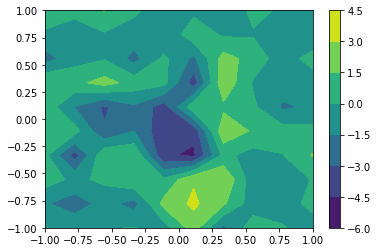

In [11]:
w0 = model_train.get_all_weights()

model_viz = Burgers_viz(0.01 / np.pi, lower_bound,upper_bound, [2,20,20,20,20,20,20,1],  add_grad_ops=True)

t1s,t2s,vals, _ = viz_hessian_eigenvalue_ratio(model_viz,X,U,X_df,w0, grid_steps=10)

plt.contourf(t1s,t2s,np.log(np.abs(vals)) )
plt.colorbar()